In [1]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import RandomSampler
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs you can use: {max_n_jobs}")
import shap

/Users/justpqa/drw-crypto-market-prediction/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Maximum n_jobs you can use: 12


In [2]:
feature_version = 2
# 1 for pc feature, 
# 2 for label correlation feature # seems to work most consistently
# 3 for best features based on combination rank

In [3]:
default_random_state = 101

#### Import train data and popular features

In [4]:
train_df = pd.read_parquet(f"data/cleaned/cleaned_train_{feature_version}.parquet")
train_df.head()

,X473,X205,X198,X444,X466,X445,X472,X26,X29,X217,...,normalized_buy_volume,normalized_sell_volume,liquidity_adjusted_imbalance,pressure_spread_interaction,trade_direction_ratio,net_buy_volume,bid_skew,ask_skew,timestamp,label
0,-0.201346,-1.978504,-1.700689,-0.142546,-0.163476,-0.128331,-0.126241,1.406392,1.474789,-0.981975,...,11.542564,5.339347,0.063569,-0.230493,0.796810,131.421,0.644635,0.355365,2023-03-01 00:00:00,0.562539
1,-0.186231,-1.830295,-1.669471,-0.135499,-0.159388,-0.124790,-0.115015,1.003783,1.312735,-0.940190,...,13.626484,137.821061,0.011610,-0.549445,0.620251,203.896,0.942921,0.057079,2023-03-01 00:01:00,0.533686
2,-0.182398,-1.803540,-1.662645,-0.133705,-0.158627,-0.123891,-0.112303,0.760801,1.219124,-0.933071,...,360.242073,2.263386,0.015877,0.530818,0.538664,22.858,0.007283,0.992717,2023-03-01 00:02:00,0.546505
3,-0.177415,-1.714013,-1.620037,-0.133251,-0.158334,-0.123658,-0.109113,0.955549,1.353001,-0.891216,...,69.011716,5.946089,0.025702,0.454780,0.728757,210.779,0.187976,0.812024,2023-03-01 00:03:00,0.357703
4,-0.174164,-1.684170,-1.600188,-0.128862,-0.156668,-0.121464,-0.106383,0.905460,1.361880,-0.878711,...,3.623647,12.867864,0.081042,-0.533689,0.689066,54.004,0.887255,0.112745,2023-03-01 00:04:00,0.362452


In [5]:
popular_features_train = pd.read_parquet("data/cleaned/popular_features_train.parquet")
popular_features_train.head()

,volume,bid_qty,ask_qty,buy_qty,sell_qty
0,221.389,15.283,8.425,176.405,44.984
1,847.796,38.590,2.336,525.846,321.950
2,295.596,0.442,60.250,159.227,136.369
3,460.705,4.865,21.016,335.742,124.963
4,142.818,27.158,3.451,98.411,44.407


#### Implement some helper function

In [6]:
# First need to split into some fold
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

default_cv = 1
# NOTE: default_cv must set to 1 instead of 3 based on consistency with LB score contains 49% of test data
# NOTE: 3 cv with gap is slightly better or almost equal

def create_cv(train_df, features=None, cv=default_cv):
    if features is not None:
        train_df = train_df[features + ["timestamp", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    for i in range(cv):
        # train_month = list(range(3 + 3 * i, 6 + 3 * i))
        train_month = [3, 4, 5, 6, 7, 8]
        # test_month = list([7 + 3 * 1, 8 + 3 * i]) if i < 2 else [1, 2]
        test_month = [9, 10, 11, 12, 1, 2] # try to make a gap to see if there is any differences in cv-lb correlation
        # print(train_month, test_month)
        train = train_df[train_df["timestamp"].dt.month.isin(train_month)].reset_index().drop("index", axis = 1)
        test = train_df[train_df["timestamp"].dt.month.isin(test_month)].reset_index().drop("index", axis = 1)
        X_train_arr.append(train.drop(["timestamp", "label"], axis = 1))
        X_test_arr.append(test.drop(["timestamp", "label"], axis = 1))
        Y_train_arr.append(train["label"])
        Y_test_arr.append(test["label"])  
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_random_test(train_df, features=None, test_cv=10):
    # randomize so that we have 1 train, but try it on 10 different test 
    if features is not None:
        train_df = train_df[features + ["timestamp", "label"]]
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []

    # Create train data
    train_month = [3, 4, 5, 6, 7, 8]
    train = train_df[train_df["timestamp"].dt.month.isin(train_month)] 
    X_train_arr.append(train.drop(["timestamp", "label"], axis = 1))
    Y_train_arr.append(train["label"])

    test_month = [9, 10, 11, 12, 1, 2]
    test = train_df[train_df["timestamp"].dt.month.isin(test_month)]
    # Create test data
    for _ in range(test_cv):
        random_test = test.sample(frac = 0.5, random_state = default_random_state)
        X_test_arr.append(random_test.drop(["timestamp", "label"], axis = 1))
        Y_test_arr.append(random_test["label"])

    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr 

In [7]:
def pearson_score(Y_test, Y_pred):
    if isinstance(Y_test, pd.Series) or isinstance(Y_test, pd.DataFrame):
        Y_test = Y_test.values
    if isinstance(Y_pred, pd.Series) or isinstance(Y_pred, pd.DataFrame):
        Y_pred = Y_pred.values
    Y_test = np.ravel(Y_test)
    Y_pred = np.ravel(Y_pred)
    return np.corrcoef(Y_test, Y_pred)[0, 1]

In [8]:
# Make function specifically for cross validation
def train_eval_cv(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr):
    cv_pearson = 0

    for i in range(cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        cv_pearson += pearson_score(Y_test, Y_pred)
    
    return cv_pearson / cv

def train_eval_cv_random_test(model, cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, test_cv = 10):
    cv_pearson = 0

    for i in range(cv):
        curr_cv_pearson = 0

        # Conduct fitting
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        
        # sampling and testing
        len_test = X_test.shape[0]
        for seed in tqdm(range(test_cv)):
            np.random.seed(seed)
            test_index = np.random.choice(len_test, size = len_test // 2, replace = False) 
            X_test_sample = X_test.loc[test_index, :]
            Y_test_sample = Y_test[test_index]
            Y_pred_sample = model.predict(X_test_sample)
            curr_cv_pearson += pearson_score(Y_test_sample, Y_pred_sample)
        
        cv_pearson += curr_cv_pearson / test_cv
    
    return cv_pearson

In [9]:
default_n_trees = 1000
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log = True), # 0.001 - 0.1 -> 0.01 - 0.05 
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), # 1.0 -> 0.2
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0, 1), 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0, 1), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBRegressor(**params)
    cv_pearson = train_eval_cv(xgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    return cv_pearson

def objective_lightgbm(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 10), # 1 - 10 => 1 - 5
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 -> 0.005 - 0.02
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMRegressor(**params)
    cv_pearson = train_eval_cv(lgbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    return cv_pearson

def objective_catboost(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), # 0.001 - 0.1 => 0.01 - 0.1
        "depth": trial.suggest_int("depth", 1, 10), #  1 - 10 => 5 - 15
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_pearson = train_eval_cv(cbr, default_cv, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    return cv_pearson

In [10]:
default_n_trials = 100
default_n_jobs = 2

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='maximize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best Pearson score:', study.best_value)
    return study.best_params

#### First iteration: training with all features from the collection (top k = 100, 500 features correlated with labels)

In [11]:
train_added_df = pd.concat([train_df, popular_features_train], axis=1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_random_test(train_added_df)

In [ ]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

In [12]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

Conduct hyperparam opt for LightGBM


[I 2025-06-13 23:23:32,924] Using an existing study with name 'lightgbm_2_1_101_1000_study' instead of creating a new one.
[I 2025-06-13 23:23:40,490] Trial 315 finished with value: 0.06130652908506217 and parameters: {'max_depth': 3, 'learning_rate': 0.007486058485556843, 'num_leaves': 167, 'subsample': 0.49234599365361514, 'colsample_bytree': 0.7783377461453082, 'min_child_weight': 0.10840099778720769, 'reg_alpha': 5.703973952921881, 'reg_lambda': 65.91215672483304}. Best is trial 50 with value: 0.0842577434859161.
[I 2025-06-13 23:24:02,372] Trial 316 finished with value: 0.05267370710912743 and parameters: {'max_depth': 6, 'learning_rate': 0.013007445219635483, 'num_leaves': 450, 'subsample': 0.9461135064202967, 'colsample_bytree': 0.559016913373675, 'min_child_weight': 0.3727270007925433, 'reg_alpha': 9.557751558894212, 'reg_lambda': 46.24237427582671}. Best is trial 50 with value: 0.0842577434859161.
[I 2025-06-13 23:24:42,445] Trial 314 finished with value: 0.07884249714760386 a

Best hyperparameters: {'max_depth': 1, 'learning_rate': 0.08598864754413953, 'num_leaves': 21, 'subsample': 0.8628729523093334, 'colsample_bytree': 0.8574205023645607, 'min_child_weight': 0.7575398213663075, 'reg_alpha': 3.50787771363934, 'reg_lambda': 2.694538901294097}
Best Pearson score: 0.0842577434859161


In [13]:
best_params_catboost = optimize_catboost(
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study",
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study"
)

[I 2025-06-13 23:46:18,626] Using an existing study with name 'catboost_2_1_101_1000_study' instead of creating a new one.


Conduct hyperparam opt for CatBoost


[I 2025-06-13 23:46:21,455] Trial 127 finished with value: 0.06427941990771277 and parameters: {'learning_rate': 0.007780219222666542, 'depth': 1, 'subsample': 0.3577424331368587, 'colsample_bylevel': 0.14295464414182588, 'min_data_in_leaf': 415, 'reg_lambda': 1.5256112760964724}. Best is trial 109 with value: 0.09578904642635608.
[I 2025-06-13 23:46:26,675] Trial 126 finished with value: 0.051345060433627 and parameters: {'learning_rate': 0.012613995262556525, 'depth': 2, 'subsample': 0.6838523906687929, 'colsample_bylevel': 0.5104622121833784, 'min_data_in_leaf': 553, 'reg_lambda': 10.269311129527747}. Best is trial 109 with value: 0.09578904642635608.
[I 2025-06-13 23:46:38,686] Trial 128 finished with value: 0.06402373921282163 and parameters: {'learning_rate': 0.020864886921690706, 'depth': 4, 'subsample': 0.8351314426017697, 'colsample_bylevel': 0.8141632230083522, 'min_data_in_leaf': 50, 'reg_lambda': 63.601226921125345}. Best is trial 109 with value: 0.09578904642635608.
[I 202

Best hyperparameters: {'learning_rate': 0.01612954137282844, 'depth': 12, 'subsample': 0.20327505924345982, 'colsample_bylevel': 0.7879751525358442, 'min_data_in_leaf': 497, 'reg_lambda': 56.425647551099026}
Best Pearson score: 0.09578904642635608


Analyze params - cv relationship

In [14]:
def get_study_df(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    study_df = []
    for trial in study.trials:
        trial_dict = trial.params
        trial_dict["value"] = trial.value
        study_df.append(trial_dict)

    return pd.DataFrame(study_df)

In [15]:
def params_value_viz(study_df):
    nrows = (study_df.shape[1] - 1) // 3 + ((study_df.shape[1] - 1) % 3 > 0)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (14, 5 * nrows))
    for inx, var in enumerate(study_df.columns):
        x, y = inx // 3, inx % 3
        if var != "value":
            sns.regplot(study_df, x = var, y = "value", ax = ax[x][y], lowess=True, line_kws={'color': 'green'}, ci = 95)
    plt.show()

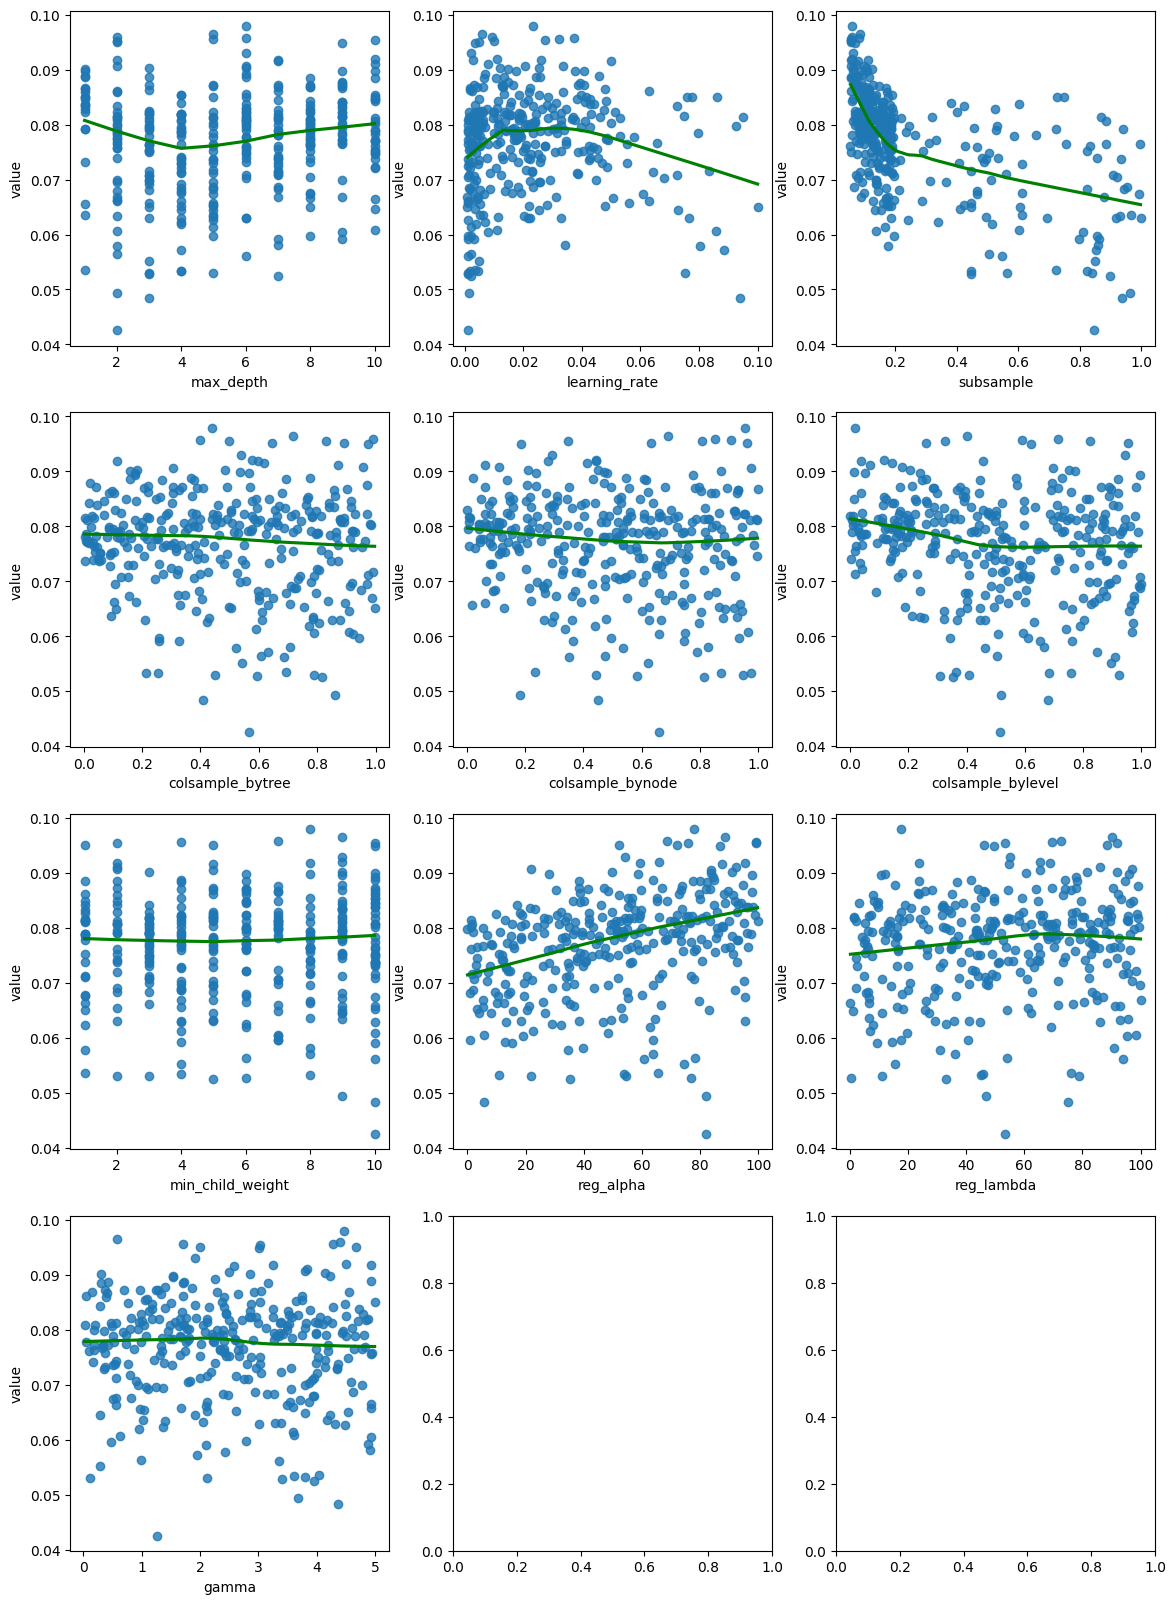

In [16]:
study_df_xgboost = get_study_df(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")   
params_value_viz(study_df_xgboost)

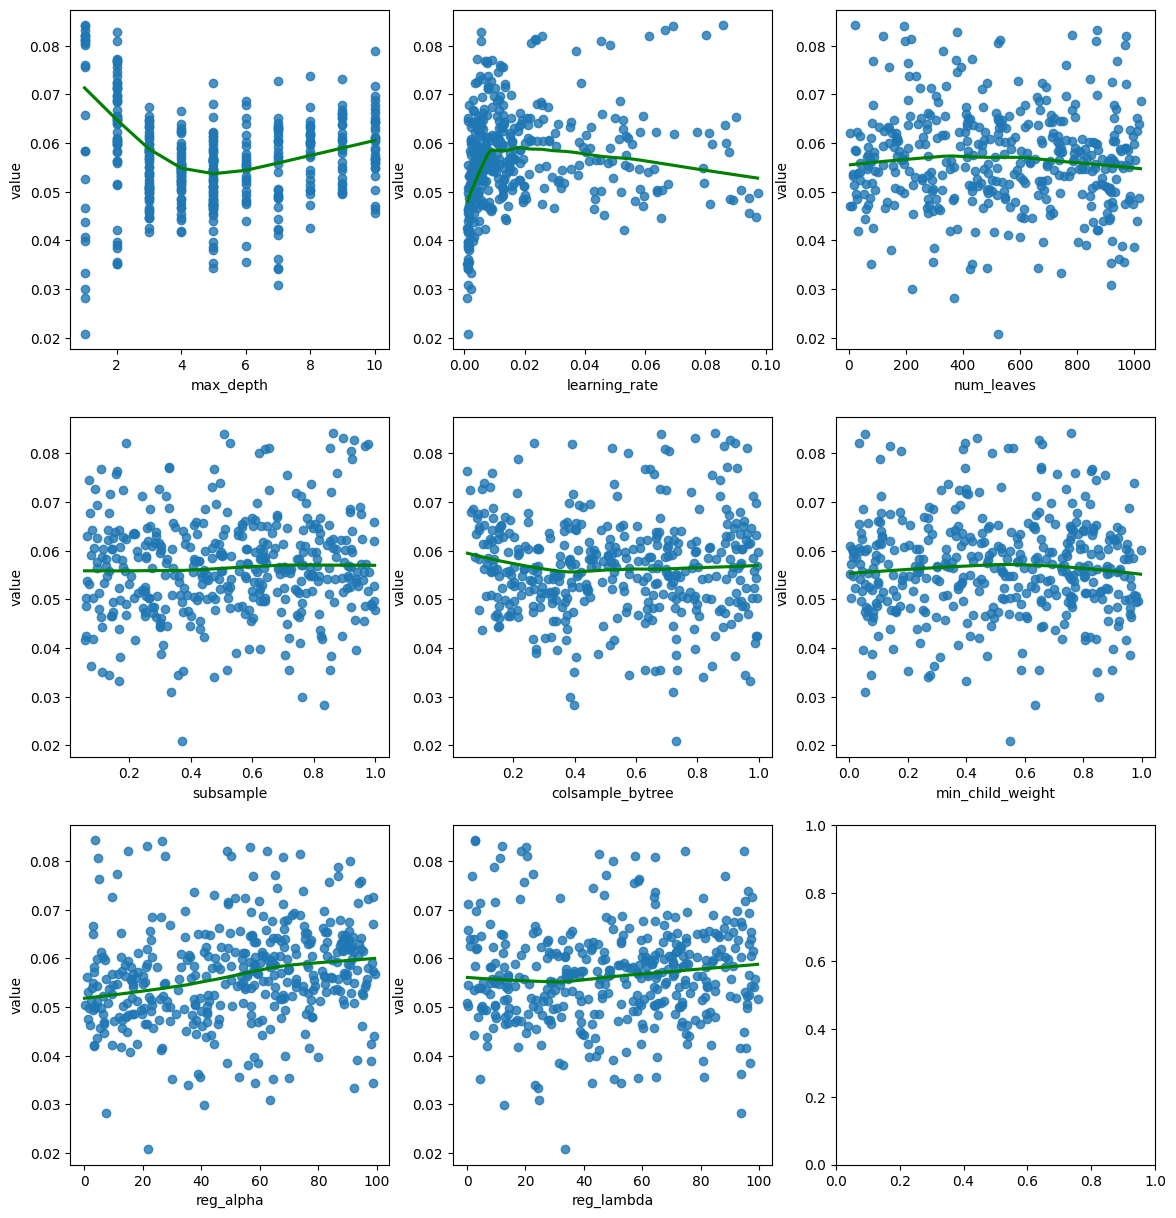

In [17]:
study_df_lightgbm = get_study_df(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
params_value_viz(study_df_lightgbm)

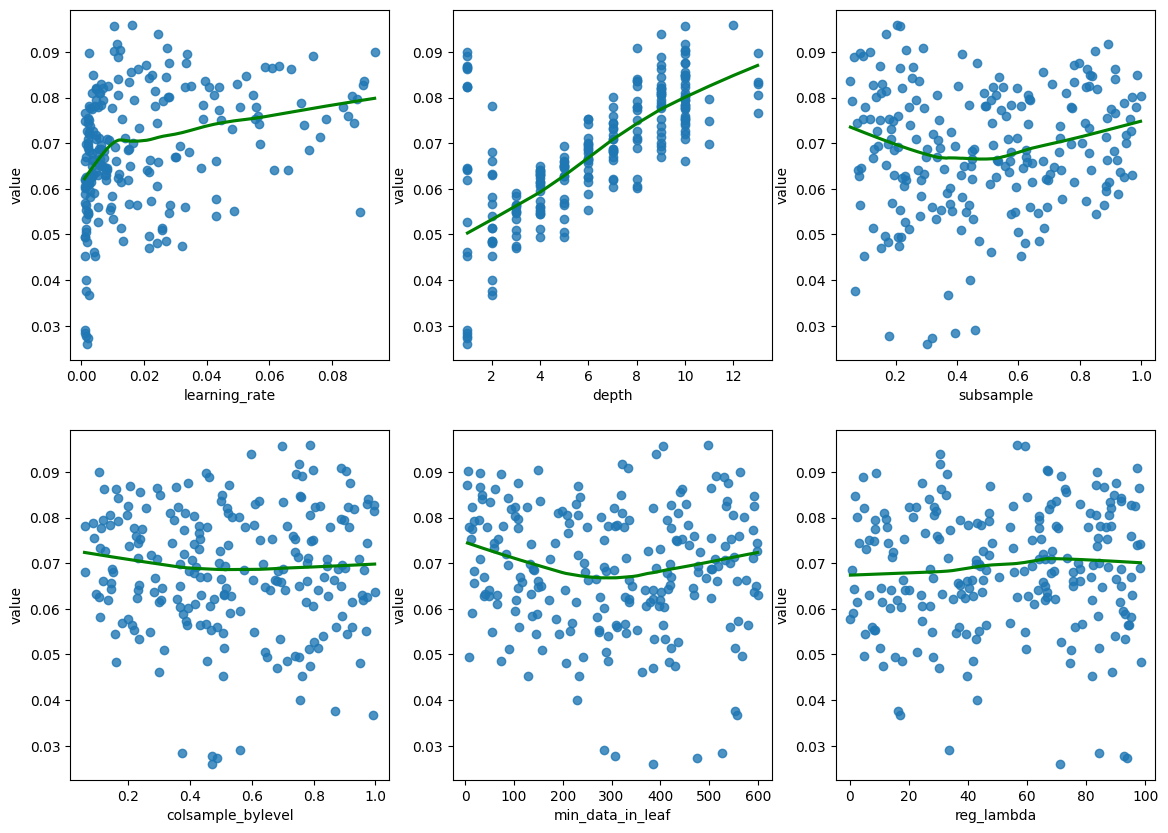

In [18]:
study_df_catboost = get_study_df(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
params_value_viz(study_df_catboost)

Analyze feature importance + CV performance

In [19]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [20]:
def get_shap_values(model, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, sample_size=10000):
    mean_abs_shap_all = np.zeros(X_train_arr[0].shape[1])
    for i in range(default_cv):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        X_test_sample = X_test.sample(sample_size, random_state = default_random_state)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)
        mean_abs_shap_all += mean_abs_shap
    mean_abs_shap_all /= default_cv
    return mean_abs_shap_all

0.0979597817802834


(array([47., 41., 28., 16.,  3.,  2.,  1.,  0.,  0.,  2.]),
 array([0.        , 0.00168169, 0.00336338, 0.00504507, 0.00672676,
        0.00840845, 0.01009014, 0.01177183, 0.01345352, 0.01513521,
        0.0168169 ]),
 <BarContainer object of 10 artists>)

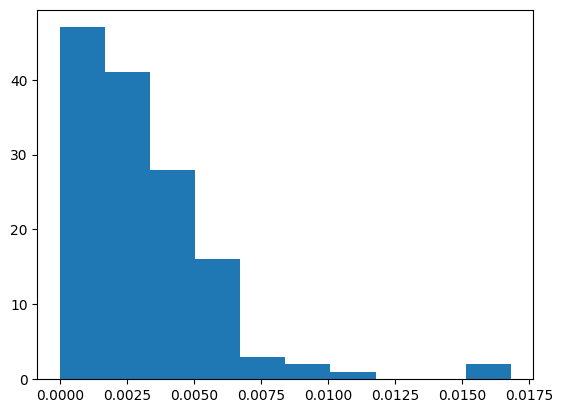

In [21]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, xgbr.predict(X_test)))
    features = xgbr.feature_names_in_.tolist()
    # features_i = xgbr.feature_importances_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [22]:
print([f for f in xgboost_feature_importances if xgboost_feature_importances[f] > 0.01])

['X533', 'X863', 'X598']


0.0842577434859161


(array([95., 19., 12.,  4.,  5.,  2.,  1.,  1.,  0.,  1.]),
 array([0.        , 0.0071666 , 0.01433319, 0.02149979, 0.02866639,
        0.03583298, 0.04299958, 0.05016618, 0.05733277, 0.06449937,
        0.07166597]),
 <BarContainer object of 10 artists>)

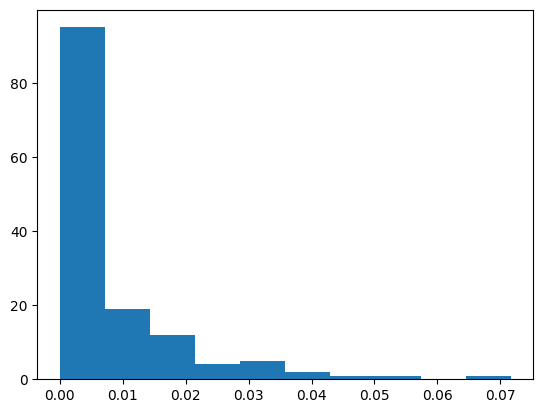

In [23]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, lgbr.predict(X_test)))
    features = lgbr.feature_names_in_.tolist()
    # features_i = lgbr.feature_importances_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [24]:
print([f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] >= 0.01])

['X198', 'X444', 'X466', 'X445', 'X137', 'X218', 'X28', 'X533', 'X226', 'X862', 'X758', 'X169', 'X89', 'X465', 'X754', 'X95', 'X861', 'X540', 'X856', 'X531', 'X297', 'X868', 'X863', 'X852', 'X272', 'X291', 'X284', 'X598', 'X379', 'X331', 'X298', 'X285', 'X292', 'X511', 'X279', 'X435', 'X296', 'X23']


0.09578904642635608


(array([70., 35., 16.,  9.,  4.,  3.,  1.,  0.,  0.,  2.]),
 array([0.        , 0.00427423, 0.00854845, 0.01282268, 0.0170969 ,
        0.02137113, 0.02564535, 0.02991958, 0.03419381, 0.03846803,
        0.04274226]),
 <BarContainer object of 10 artists>)

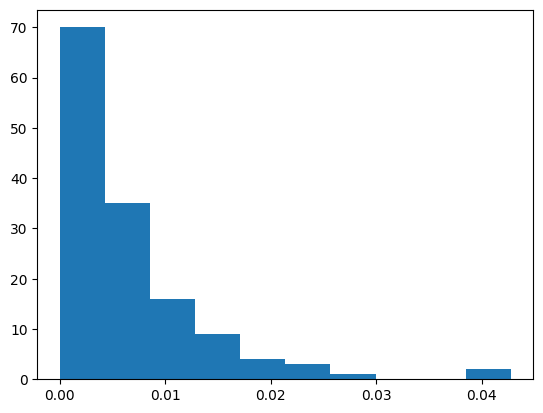

In [25]:
params = {
    "iterations": default_n_trees,
    "verbose": False,
    "random_seed": default_random_state
}
best_params_catboost = get_best_params_from_file(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_study")
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

catboost_feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(default_cv):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    cbr.fit(X_train, Y_train)
    print(pearson_score(Y_test, cbr.predict(X_test)))
    features = cbr.feature_names_
    # features_i = cbr.feature_importances_.tolist()
    features_i = get_shap_values(cbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        catboost_feature_importances[feat] = catboost_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(catboost_feature_importances.values())
# can pick up a combination of both past cod and tss, not good at picking up ph, temp

In [26]:
print([f for f in catboost_feature_importances if catboost_feature_importances[f] >= 0.02])

['X533', 'X862', 'X861', 'X856', 'X863', 'X598', 'X379', 'X331']


Get top 20 important features in all of them

In [27]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
catboost_feature_importances_df = pd.DataFrame(
    {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
)
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
feature_importances_df = feature_importances_df.merge(
    catboost_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("", "_catboost")
)
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df["importance"] = 1/3 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"] + feature_importances_df["importance_catboost"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df[:50]

,var,importance_xgboost,importance_lightgbm,importance_catboost,importance
0,X862,0.006154,0.071666,0.038994,0.038938
1,X598,0.015574,0.049998,0.042742,0.036105
2,X863,0.016817,0.051960,0.028090,0.032289
3,X533,0.011051,0.033464,0.021885,0.022133
4,X379,0.004740,0.036288,0.021051,0.020693
5,X856,0.008945,0.026276,0.024099,0.019774
6,X28,0.008866,0.033403,0.015541,0.019270
7,X284,0.005563,0.037156,0.012314,0.018345
8,X466,0.002530,0.035473,0.014160,0.017388
9,X95,0.001246,0.033516,0.013721,0.016161


#### Second iteration: a more truncated version from the first collection

XGBoost

In [ ]:
xgboost_importance_threshold = 0.011
xgboost_best_features = [
    f for f in xgboost_feature_importances if xgboost_feature_importances[f] > xgboost_importance_threshold
] + ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"]
print(len(xgboost_best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, xgboost_best_features)

In [ ]:
best_xgboost_params_truncated = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study"
) # much worse than using all features  

LightGBM

In [ ]:
lightgbm_importance_threshold = 20
lightgbm_best_features = [
    f for f in lightgbm_feature_importances if lightgbm_feature_importances[f] > lightgbm_importance_threshold
] + ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"]
print(len(lightgbm_best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, lightgbm_best_features)

In [ ]:
best_lightgbm_params_truncated = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_truncated_study"
)
# also much worse 

##### Third Iteration: a common truncated version using good features across all models + popular features

In [28]:
best_features = feature_importances_df.loc[:29, "var"].tolist() + \
                ["volume", "bid_qty", "ask_qty", "buy_qty", "sell_qty"] + \
                [col for col in train_df.columns.tolist() if "X" not in col and col not in ["timestamp", "label"]]
best_features = list(set(best_features))
train_added_df = pd.concat([train_df, popular_features_train], axis=1)
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv(train_added_df, best_features)

XGBoost

In [29]:
best_xgboost_params_common_truncated = optimize_xgboost(
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study",
    f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study"
) 

[I 2025-06-14 00:13:00,363] Using an existing study with name 'xgboost_2_1_101_1000_common_truncated_study' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-06-14 00:13:06,308] Trial 307 finished with value: 0.09453939178403546 and parameters: {'max_depth': 3, 'learning_rate': 0.02055854772973974, 'subsample': 0.5910183355266372, 'colsample_bytree': 0.9925700497361492, 'colsample_bynode': 0.05600056882135973, 'colsample_bylevel': 0.8652920362975862, 'min_child_weight': 8, 'reg_alpha': 49.32471569312563, 'reg_lambda': 59.677577240273685, 'gamma': 0.9501028770857756}. Best is trial 62 with value: 0.10917151660155144.
[I 2025-06-14 00:13:10,151] Trial 306 finished with value: 0.07105178114197676 and parameters: {'max_depth': 10, 'learning_rate': 0.06300577148584831, 'subsample': 0.5709994443210451, 'colsample_bytree': 0.7712667215590799, 'colsample_bynode': 0.6899791903835658, 'colsample_bylevel': 0.9745906439781923, 'min_child_weight': 8, 'reg_alpha': 25.966449356915845, 'reg_lambda': 73.75267910614632, 'gamma': 0.88037632294105}. Best is trial 62 with value: 0.10917151660155144.
[I 2025-06-14 00:13:12,215] Trial 308 finished with va

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.030236406793740882, 'subsample': 0.05387041807091989, 'colsample_bytree': 0.10258599559195569, 'colsample_bynode': 0.3976821329503406, 'colsample_bylevel': 0.8641125934247766, 'min_child_weight': 3, 'reg_alpha': 97.10882564346419, 'reg_lambda': 47.881820097790055, 'gamma': 1.6938079956211882}
Best Pearson score: 0.10917151660155144


LightGBM

In [30]:
best_lightgbm_params_common_truncated = optimize_lightgbm(
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study",
    f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study"
)
# slightly worse

[I 2025-06-14 00:19:47,406] Using an existing study with name 'lightgbm_2_1_101_1000_common_truncated_study' instead of creating a new one.


Conduct hyperparam opt for LightGBM


[I 2025-06-14 00:19:50,686] Trial 210 finished with value: 0.04763585594959977 and parameters: {'max_depth': 2, 'learning_rate': 0.0012969505999440014, 'num_leaves': 458, 'subsample': 0.5774864994952055, 'colsample_bytree': 0.27864028999828244, 'min_child_weight': 0.41384820507657005, 'reg_alpha': 20.21422561521242, 'reg_lambda': 99.41665635352336}. Best is trial 25 with value: 0.10271200010182333.
[I 2025-06-14 00:19:54,716] Trial 211 finished with value: 0.08360115506826676 and parameters: {'max_depth': 3, 'learning_rate': 0.0023629560804023825, 'num_leaves': 847, 'subsample': 0.9135232633403427, 'colsample_bytree': 0.12143706869464793, 'min_child_weight': 0.2976844589937063, 'reg_alpha': 88.57832371403089, 'reg_lambda': 41.82144553761595}. Best is trial 25 with value: 0.10271200010182333.
[I 2025-06-14 00:19:59,328] Trial 209 finished with value: 0.07672374257920288 and parameters: {'max_depth': 5, 'learning_rate': 0.049252120789158284, 'num_leaves': 221, 'subsample': 0.491188506811

Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.0019002465720082096, 'num_leaves': 576, 'subsample': 0.9914169337493205, 'colsample_bytree': 0.10121401454540106, 'min_child_weight': 0.5756616105062986, 'reg_alpha': 33.74025811955384, 'reg_lambda': 99.9127116532871}
Best Pearson score: 0.10957822474660724


Catboost

In [31]:
best_catboost_params_common_truncated = optimize_catboost(
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study",
    f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study"
)


[I 2025-06-14 00:40:30,264] Using an existing study with name 'catboost_2_1_101_1000_common_truncated_study' instead of creating a new one.


Conduct hyperparam opt for CatBoost


[I 2025-06-14 00:40:34,126] Trial 280 finished with value: 0.0818554787279658 and parameters: {'learning_rate': 0.08979059779789975, 'depth': 2, 'subsample': 0.8822934103916287, 'colsample_bylevel': 0.07405155132560955, 'min_data_in_leaf': 209, 'reg_lambda': 10.060827044125142}. Best is trial 7 with value: 0.10226990458774099.
[I 2025-06-14 00:40:38,637] Trial 279 finished with value: 0.08626754549441186 and parameters: {'learning_rate': 0.06457758936953893, 'depth': 4, 'subsample': 0.6272383856012781, 'colsample_bylevel': 0.4621209466861623, 'min_data_in_leaf': 582, 'reg_lambda': 58.40176159900129}. Best is trial 7 with value: 0.10226990458774099.
[I 2025-06-14 00:40:48,907] Trial 282 finished with value: 0.07624046376993963 and parameters: {'learning_rate': 0.06921610737046928, 'depth': 5, 'subsample': 0.5003175578784095, 'colsample_bylevel': 0.9810217699327745, 'min_data_in_leaf': 562, 'reg_lambda': 13.174880523819644}. Best is trial 7 with value: 0.10226990458774099.
[I 2025-06-14 

Best hyperparameters: {'learning_rate': 0.026168917343911073, 'depth': 9, 'subsample': 0.4629446397440669, 'colsample_bylevel': 0.08394664928222302, 'min_data_in_leaf': 235, 'reg_lambda': 15.111918492671862}
Best Pearson score: 0.10226990458774099


Analyze param search

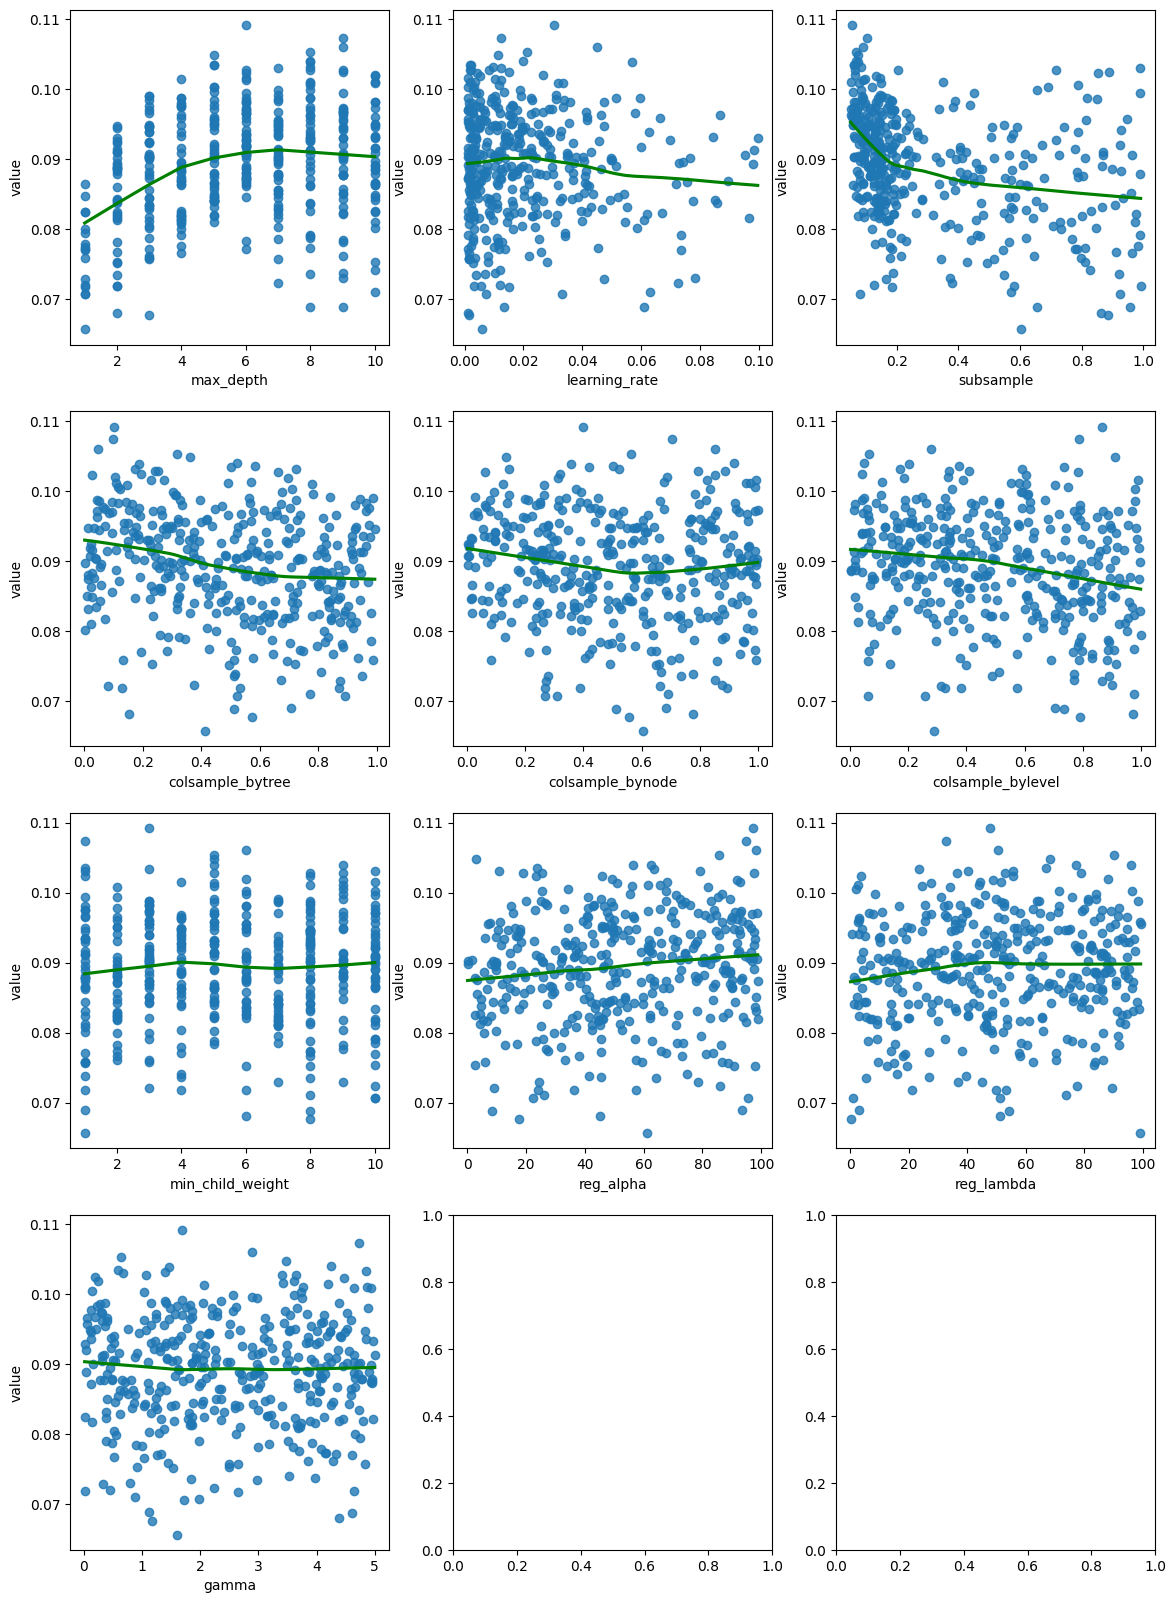

In [32]:
study_df_xgboost = get_study_df(f"xgboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study")   
params_value_viz(study_df_xgboost)

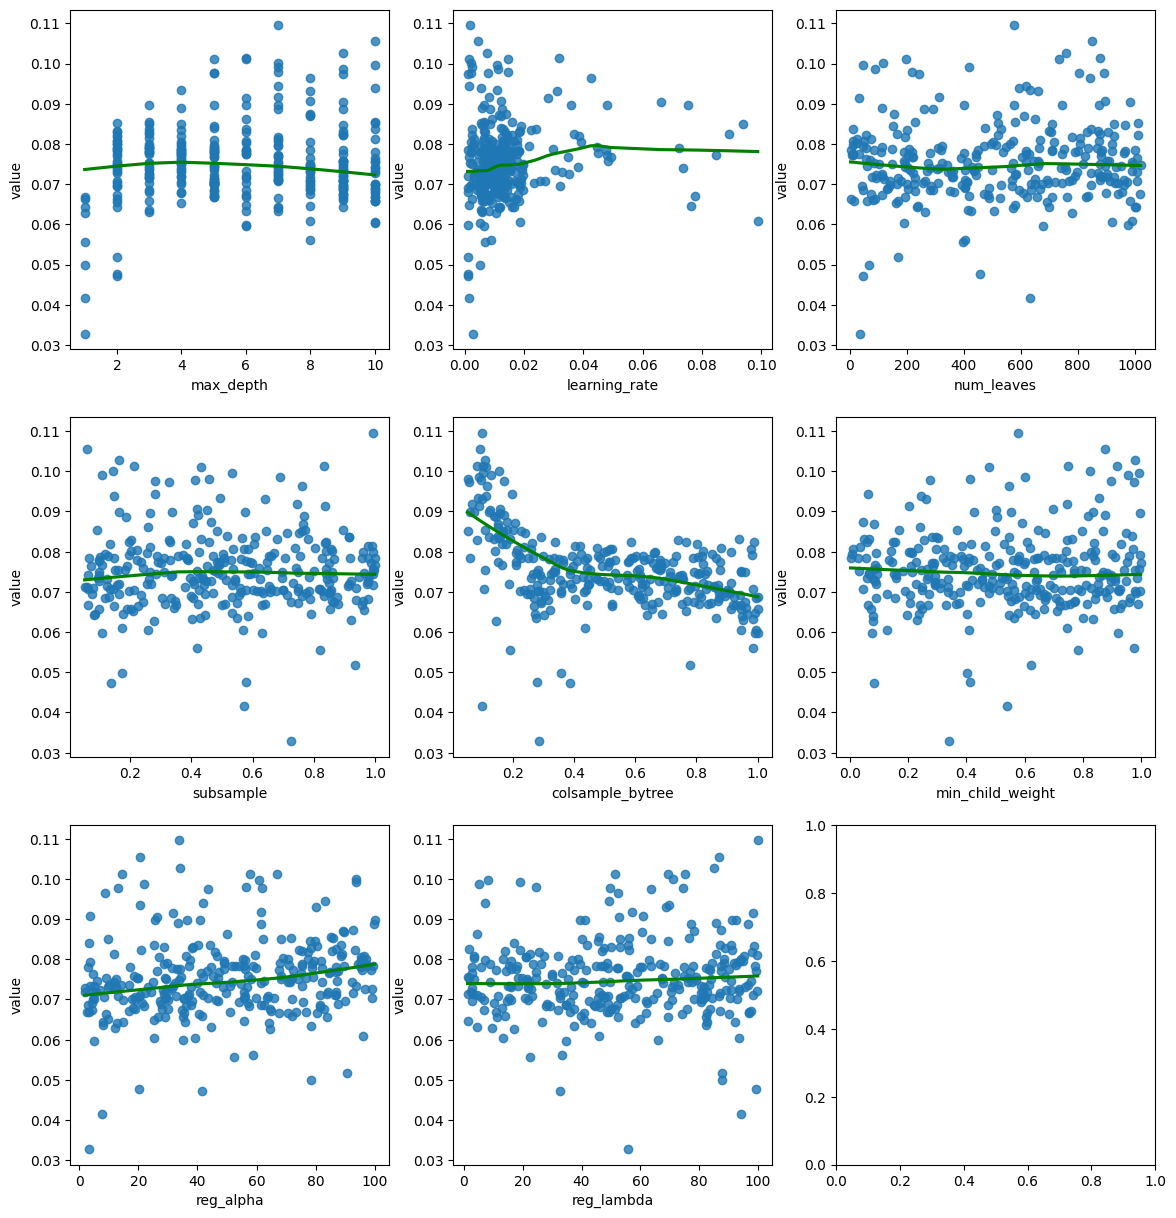

In [33]:
study_df_lightgbm = get_study_df(f"lightgbm_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study")   
params_value_viz(study_df_lightgbm)

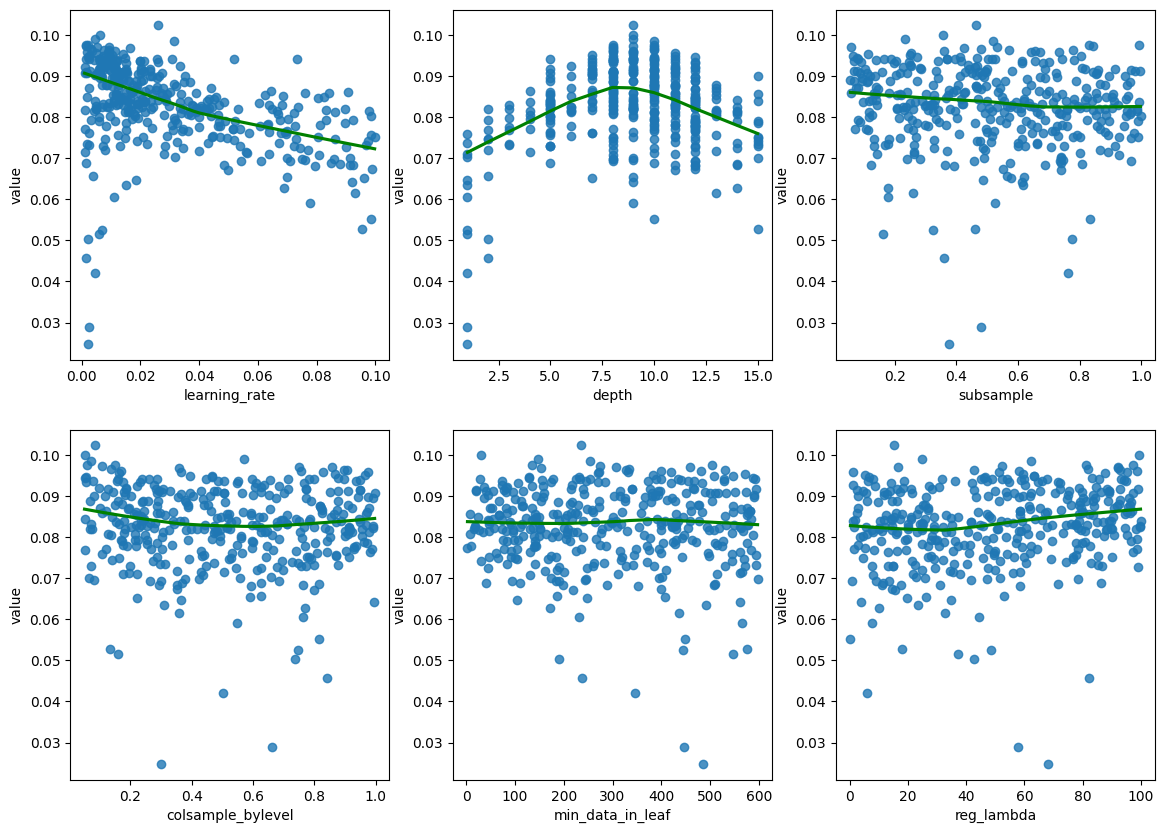

In [34]:
study_df_catboost = get_study_df(f"catboost_{feature_version}_{default_cv}_{default_random_state}_{default_n_trees}_common_truncated_study")   
params_value_viz(study_df_catboost)